In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt

from keras.models import load_model

Using TensorFlow backend.


## Prediction of Closing Price of Stock LSTM
The goal is to predict the Closing Price behavior of a single company by predicting `n` coming days (`forward_days`), using as input the `m` past days (`look_back`).

### (Prevendo o preço de uma ação no mercado de ações)

O objetivo é prever o que acontecerá com o valor de fechamento de uma ação em `n` dias (`forward_days`), tendo como base os `m` dias anteriores (`look_back`).

In [2]:
look_back = 40
forward_days = 10
num_periods = 20

First, just open the CSV using Pandas, set the `Date` as index and keep only the Closing Price column.

Primeiro, vamos abrir o CSV com o Pandas, colocar as datas como index e manter apenas a coluna que queremos prever, que é o preço de fechamento.

In [3]:
#open the csv, chose company_N, where N = {A, B, C or D}
df = pd.read_csv('data/samsung.csv')
#set date as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#keep only the 'Close' column
df = df['Close']

df.head()

Date
2010-01-08    16420.0
2010-01-11    15940.0
2010-01-12    16180.0
2010-01-13    15940.0
2010-01-14    16540.0
Name: Close, dtype: float64

In [4]:
len(df)

2220

### Data visualization  ( Vizualizando os dados )

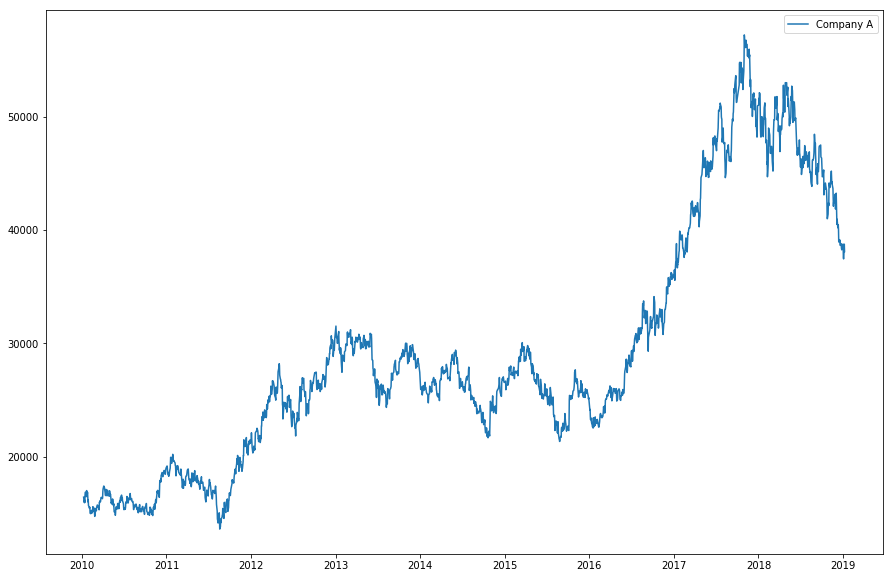

In [5]:
plt.figure(figsize = (15,10))
plt.plot(df, label='Company A')
plt.legend(loc='best')
plt.show()

### Data normalization  ( Normalizando os dados )

In [6]:
array = df.values.reshape(df.shape[0],1)
array[:5]

array([[16420.],
       [15940.],
       [16180.],
       [15940.],
       [16540.]])

In [7]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.06464924],
       [0.05364512],
       [0.05914718],
       [0.05364512],
       [0.06740028]])

### Split the data in Data to Train/Validate the LSTM and Data to Test the model

The Test set will be the last `k` (`num_periods`) periods we want test the model. In each period, the model will predict the next `n` coming days. The remaning data will be used for Train/Validation.

### ( Dividir os dados em Treino/Validação para o modelo LSTM e os dados de Teste)
Vamos separar para os últimos `k` períodos (`num_periods`) para testar o modelo. A cada período, o modelo irá prever os próximos `n` dias. O resto será utilizado para o treinamento (Treino e Validação).

In [8]:
#split in Train and Test

division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [9]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [10]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)

(1576, 40, 1)
(395, 40, 1)
(20, 40, 1)
(1576, 10)
(395, 10)
(20, 10)


## Training the LSTM (Treinando a LSTM)

In [12]:
#Optionaly, you ca'Trained/n load a model
model = load_model('Trained/single-company/LSTM_compA_LB40_FD10_E50_F50_S30.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [14]:
NUM_NEURONS_FirstLayer = 4
NUM_NEURONS_SecondLayer = 4
 
EPOCHS = 4

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Train on 1576 samples, validate on 395 samples
Epoch 1/4
 - 34s - loss: 0.0361 - val_loss: 0.0031
Epoch 2/4
 - 32s - loss: 0.0019 - val_loss: 0.0014
Epoch 3/4
 - 32s - loss: 0.0013 - val_loss: 0.0012
Epoch 4/4
 - 32s - loss: 0.0012 - val_loss: 0.0011


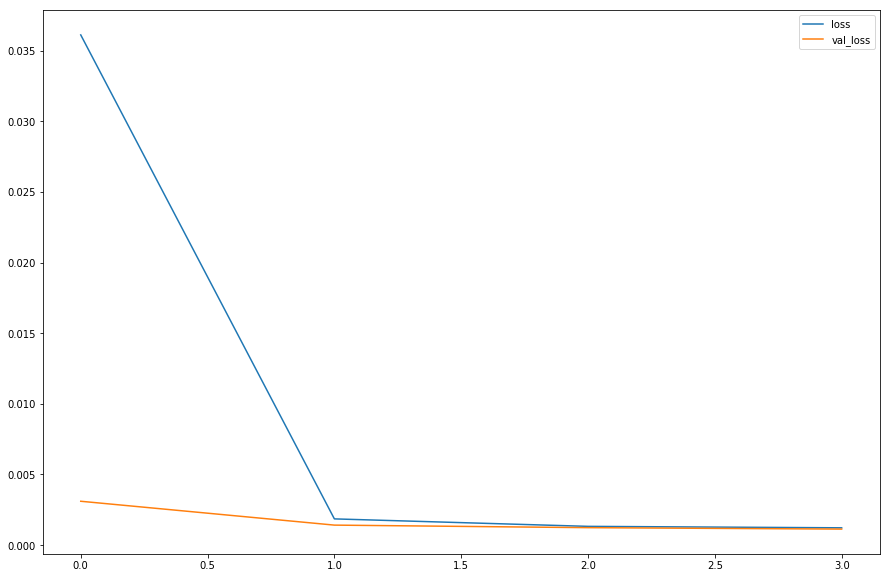

In [15]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [16]:
#Saving the model
file_name = 'Trained/single-company/LSTM_compA_LB{}_FD{}_E{}_F{}_S{}.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `Trained/single-company/LSTM_compA_LB40_FD10_E4_F4_S4.h5` to disk


### Predicting the Test Set to see the results  ( Vamos prever os dados de Teste para o resultado )

In [17]:
Xt = model.predict(X_test)

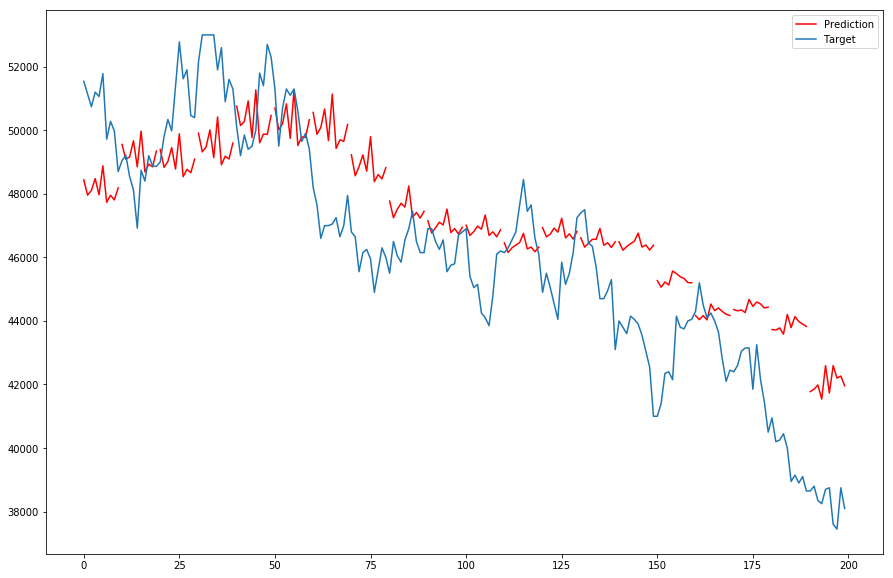

In [18]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

### Predicting all the data to see how the model reacts to Train and Test set
#### (Prever todos os dados para ver como o modelo reage aos dados de Treino e Teste)

In [19]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [20]:
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

In [21]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

In [22]:
y = np.concatenate((ytrain, ytest), axis=0)

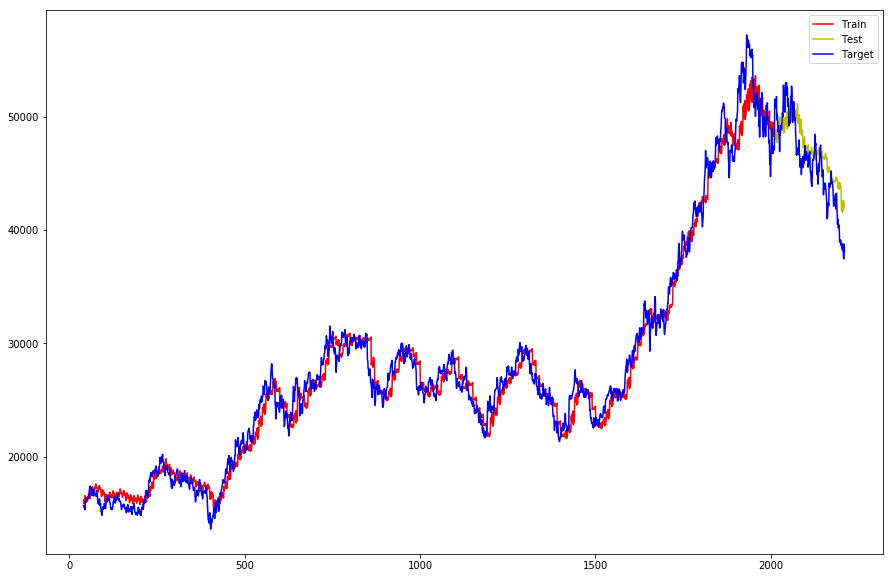

In [23]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data used
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()